# LSTM Stock Predictor Using Closing Prices

## Data Preparation

In [24]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [25]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [26]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [27]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [28]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [29]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [30]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [106]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [107]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
y_train = y[: split]

X_test = X[split:]
y_test = y[split:]

In [108]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [109]:
# Reshape the features for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [110]:
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]]

 [[0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]]

 [[0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]
  [0.58660203]]

 [[0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]
  [0.58660203]
  [0.5487353 ]]

 [[0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]
  [0.58660203]
  [0.5487353 ]
  [0.64593307]]] 

X_test sample values:
[[[0.04675556]
  [0.03913222]
  [0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]]

 [[0.03913222]
  [0.03975922]
  [0.038567

## Build and Train the LSTM RNN

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [112]:
# Build the LSTM model

# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [113]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [114]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 30)            3840      
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 30)            7320      
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [115]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
372/372 [==============================] - 5s 7ms/step - loss: 0.0654
Epoch 2/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0474
Epoch 3/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0604
Epoch 4/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0603
Epoch 5/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0586
Epoch 6/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0512
Epoch 7/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0433
Epoch 8/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0375
Epoch 9/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0380
Epoch 10/10
372/372 [==============================] - 3s 7ms/step - loss: 0.0342


## Model Performance

In [116]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 7ms/step - loss: 0.0562


0.056236933916807175

In [117]:
# Make some predictions
predicted = model.predict(X_test)

In [118]:
predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [119]:
# Create a DataFrame of Real and Predicted values
btc = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
btc.tail()

,Real,Predicted
2019-07-25,9772.139648,6857.245117
2019-07-26,9882.429688,6842.438477
2019-07-27,9847.450195,6820.289062
2019-07-28,9478.320313,6802.727051
2019-07-29,9531.769531,6777.297852


<AxesSubplot:>

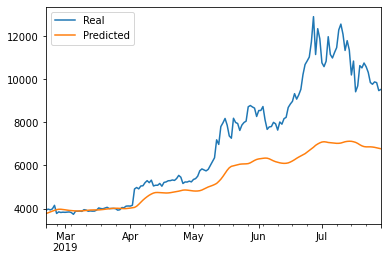

In [120]:
# Plot the real vs predicted prices as a line chart
btc.plot()